# Working with time series data
In this notebook, we will use a slightly more complicated model than in the previous notebook.
The model represents the control of indoor CO2 levels in a building.
The instantiation of component models and connections can be packed in a single function "fcn", which is then used to create the model.
Instead of "model.add_connection()" we will use "self.add_connection()" to add connections to the model.

In [1]:
# %pip install git+https://github.com/JBjoernskov/Twin4Build.git
import sys
import os
if __name__ == '__main__':
    file_path = r"C:\Users\jabj\OneDrive - Syddansk Universitet\PhD_Project_Jakob\Twin4build\python\BuildingEnergyModel\Twin4Build"
    sys.path.append(file_path)
import twin4build as tb

def fcn(self):
    ##############################################################
    ################## First, define components ##################
    ##############################################################
    occupancy_schedule = tb.ScheduleSystem(
        weekDayRulesetDict={
            "ruleset_default_value": 0,
            "ruleset_start_minute": [0, 0, 0, 0, 0, 0, 0],
            "ruleset_end_minute": [0, 0, 0, 0, 0, 0, 0],
            "ruleset_start_hour": [6, 7, 8, 12, 14, 16, 18],
            "ruleset_end_hour": [7, 8, 12, 14, 16, 18, 22],
            "ruleset_value": [3, 5, 20, 25, 27, 7, 3]},
        add_noise=True,
        saveSimulationResult=True,
        id="Occupancy schedule")
    
    co2_setpoint_schedule = tb.ScheduleSystem(
        weekDayRulesetDict={
            "ruleset_default_value": 900,
            "ruleset_start_minute": [],
            "ruleset_end_minute": [],
            "ruleset_start_hour": [],
            "ruleset_end_hour": [],
            "ruleset_value": []},
        saveSimulationResult=True,
        id="CO2 setpoint schedule")

    co2_property = tb.Co2()
    co2_controller = tb.PIDControllerSystem(
        observes=co2_property,
        K_p=-0.001,
        K_i=-0.001,
        K_d=0,
        saveSimulationResult=True,
        id="CO2 controller")

    supply_damper = tb.DamperSystem(
        nominalAirFlowRate=tb.PropertyValue(hasValue=1.6),
        a=5,
        saveSimulationResult=True,
        id="Supply damper")

    return_damper = tb.DamperSystem(
        nominalAirFlowRate=tb.PropertyValue(hasValue=1.6),
        a=5,
        saveSimulationResult=True,
        id="Return damper")

    space = tb.BuildingSpaceCo2System(
        airVolume=466.54,
        outdoorCo2Concentration=500,
        infiltration=0.005,
        generationCo2Concentration=0.0042*1000*1.225,
        saveSimulationResult=True,
        id="Space")
    co2_property.isPropertyOf = space

    #################################################################
    ################## Add connections to the model #################
    #################################################################
    self.add_connection(co2_controller, supply_damper,
                         "inputSignal", "damperPosition")
    self.add_connection(co2_controller, return_damper,
                         "inputSignal", "damperPosition")
    self.add_connection(supply_damper, space,
                         "airFlowRate", "supplyAirFlowRate")
    self.add_connection(return_damper, space,
                         "airFlowRate", "returnAirFlowRate")
    self.add_connection(occupancy_schedule, space,
                         "scheduleValue", "numberOfPeople")
    self.add_connection(space, co2_controller,
                         "indoorCo2Concentration", "actualValue")
    self.add_connection(co2_setpoint_schedule, co2_controller,
                         "scheduleValue", "setpointValue")




C:\Users\jabj\OneDrive - Syddansk Universitet\PhD_Project_Jakob\Twin4build\python\BuildingEnergyModel\Twin4Build\twin4build\utils\get_main_dir.py:12: UserWarning: Could not determine main module path, using temp dir: C:\Users\jabj\AppData\Local\Temp\1
  warnings.warn("Could not determine main module path, using temp dir: %s" % d)



Loading model...
   |___Drawing parsed object graph...done
   |___Applying user defined function...done
   |___Drawing system graph...done
   |___Validating model...done
   |___Determining execution order...done
   |___Creating execution graph...done
   |___Drawing system graph without cycles...done
   |___Loading parameters...
+---------------------------------------------------------------------+
|                  Model overview    id: co2_control                  |
+--------------------------------------------+------------------------+
| Number of components in simulation model:  |           6            |
+--------------------------------------------+------------------------+
|   Number of edges in simulation model:     |           7            |
+--------------------------------------------+------------------------+
|   Number of objects in semantic model:     |           6            |
+--------------------------------------------+------------------------+
|   Number of triples

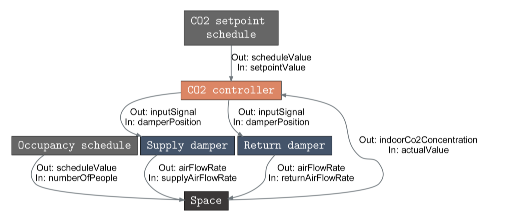

In [2]:
import matplotlib.pyplot as plt
import os
model = tb.Model(id="co2_control")
model.load(fcn=fcn)
system_graph = os.path.join(model.graph_path, "system_graph.png")
image = plt.imread(system_graph)
plt.figure()
plt.imshow(image)
plt.axis('off')
plt.show()

Now that we have a model, we can simulate it using the Simulator class. We will simulate the model for 2 days and plot the results.

100%|██████████| 288/288 [00:00<00:00, 19936.62it/s]


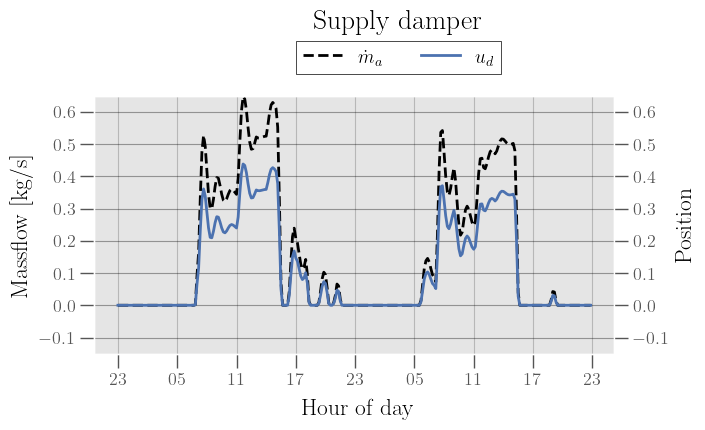

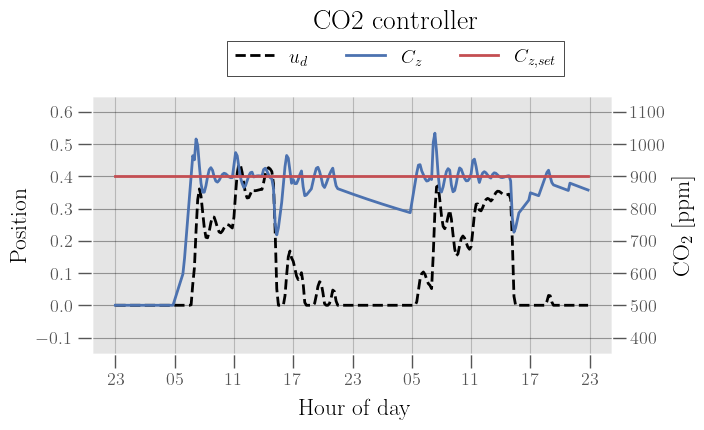

In [14]:
import datetime
from dateutil import tz
import twin4build.utils.plot.plot as plot
simulator = tb.Simulator()
stepSize = 600 #Seconds
startTime = datetime.datetime(year=2024, month=1, day=10, hour=0, minute=0, second=0, tzinfo=tz.gettz("Europe/Copenhagen"))
endTime = datetime.datetime(year=2024, month=1, day=12, hour=0, minute=0, second=0, tzinfo=tz.gettz("Europe/Copenhagen"))

# Simulate the model
simulator.simulate(model,
                    stepSize=stepSize,
                    startTime = startTime,
                    endTime = endTime)
plot.plot_damper(model, simulator, "Supply damper", show=False) #Set show=True to plot
plot.plot_CO2_controller(model, simulator, "CO2 controller", show=True) #Set show=True to plot